### **Install requirements**

In [0]:
# Colab URL: https://colab.research.google.com/drive/1Lbxl_3lu1E1uxJKjm_acQkgXqBvjFbsN#scrollTo=LjX6UizGdU3K

!pip3 install 'torch'
!pip3 install 'torchvision'
!pip3 install 'Pillow-SIMD'
!pip3 install 'utils'
!pip3 install 'livelossplot'
!pip3 install 'tqdm'

### **Import libraries**

In [0]:
import os
import logging
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Subset, DataLoader, random_split, Sampler, ConcatDataset
from torch.backends import cudnn
import torchvision
from torchvision import transforms
from torchvision.models import alexnet, resnext101_32x8d, inception_v3
from torchvision.models.inception import InceptionAux
from torchvision.datasets import VisionDataset
from PIL import Image
from tqdm import tqdm
from pandas import read_csv
import copy
from livelossplot import PlotLosses
import os.path
import sys
import numpy as np
from torchvision import datasets
from torch.utils.data.sampler import SubsetRandomSampler

### **Constant definition**

In [0]:

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Device is: ' + DEVICE)

NUM_CLASSES = 101    # 101 + 1: There is am extra Background class that should be removed 
LOG_FREQUENCY = 5

# Epochs after which the graphs draw the updated logs
FREQDRAW = 2



# inception_v3 hyperparameters (below all the parameters used in the Homework)
BATCH_SIZE = 50     # Higher batch sizes allows for larger learning rates. An empirical heuristic suggests that, when changing
                     # the batch size, learning rate should change by the same factor to have comparable results
LR = 3e-3            # The initial Learning Rate
MOMENTUM = 0.9       # Hyperparameter for SGD, keep this at 0.9 when using SGD
WEIGHT_DECAY = 5e-5  # Regularization, you can keep this at the default
NUM_EPOCHS = 15      # Total number of training epochs (iterations over dataset)
STEP_SIZE = 13       # How many epochs before decreasing learning rate (if using a step-down policy)
GAMMA = 0.5          # Multiplicative factor for learning rate step-down


'''
# 2C 1st hyperparameters
BATCH_SIZE = 964     # Higher batch sizes allows for larger learning rates. An empirical heuristic suggests that, when changing
                     # the batch size, learning rate should change by the same factor to have comparable results
LR = 1e-1            # The initial Learning Rate
MOMENTUM = 0.9       # Hyperparameter for SGD, keep this at 0.9 when using SGD
WEIGHT_DECAY = 5e-5  # Regularization, you can keep this at the default
NUM_EPOCHS = 30      # Total number of training epochs (iterations over dataset)
STEP_SIZE = 10       # How many epochs before decreasing learning rate (if using a step-down policy)
GAMMA = 0.6          # Multiplicative factor for learning rate step-down

# 2C 2nd hyperparameters
BATCH_SIZE = 964     # Higher batch sizes allows for larger learning rates. An empirical heuristic suggests that, when changing
                     # the batch size, learning rate should change by the same factor to have comparable results
LR = 7e-2            # The initial Learning Rate
MOMENTUM = 0.9       # Hyperparameter for SGD, keep this at 0.9 when using SGD
WEIGHT_DECAY = 5e-5  # Regularization, you can keep this at the default
NUM_EPOCHS = 40      # Total number of training epochs (iterations over dataset)
STEP_SIZE = 10       # How many epochs before decreasing learning rate (if using a step-down policy)
GAMMA = 0.9          # Multiplicative factor for learning rate step-down


# 3C 1st hyperparameters
BATCH_SIZE = 964     # Higher batch sizes allows for larger learning rates. An empirical heuristic suggests that, when changing
                     # the batch size, learning rate should change by the same factor to have comparable results
LR = 5e-3            # The initial Learning Rate
MOMENTUM = 0.9       # Hyperparameter for SGD, keep this at 0.9 when using SGD
WEIGHT_DECAY = 5e-5  # Regularization, you can keep this at the default
NUM_EPOCHS = 30      # Total number of training epochs (iterations over dataset)
STEP_SIZE = 25       # How many epochs before decreasing learning rate (if using a step-down policy)
GAMMA = 0.5          # Multiplicative factor for learning rate step-down

# 3C 2nd hyperparameters and 3D and 3E
BATCH_SIZE = 964     # Higher batch sizes allows for larger learning rates. An empirical heuristic suggests that, when changing
                     # the batch size, learning rate should change by the same factor to have comparable results
LR = 2e-2            # The initial Learning Rate
MOMENTUM = 0.9       # Hyperparameter for SGD, keep this at 0.9 when using SGD
WEIGHT_DECAY = 5e-5  # Regularization, you can keep this at the default
NUM_EPOCHS = 30      # Total number of training epochs (iterations over dataset)
STEP_SIZE = 25       # How many epochs before decreasing learning rate (if using a step-down policy)
GAMMA = 0.5          # Multiplicative factor for learning rate step-down

# 3C 3rd hyperparameters
BATCH_SIZE = 964     # Higher batch sizes allows for larger learning rates. An empirical heuristic suggests that, when changing
                     # the batch size, learning rate should change by the same factor to have comparable results
LR = 2e-3            # The initial Learning Rate
MOMENTUM = 0.9       # Hyperparameter for SGD, keep this at 0.9 when using SGD
WEIGHT_DECAY = 5e-5  # Regularization, you can keep this at the default
NUM_EPOCHS = 40      # Total number of training epochs (iterations over dataset)
STEP_SIZE = 10       # How many epochs before decreasing learning rate (if using a step-down policy)
GAMMA = 0.5          # Multiplicative factor for learning rate step-down


# resnext101_32x8d hyperparameters
BATCH_SIZE = 50     # Higher batch sizes allows for larger learning rates. An empirical heuristic suggests that, when changing
                     # the batch size, learning rate should change by the same factor to have comparable results
LR = 4e-4            # The initial Learning Rate
MOMENTUM = 0.9       # Hyperparameter for SGD, keep this at 0.9 when using SGD
WEIGHT_DECAY = 5e-5  # Regularization, you can keep this at the default
NUM_EPOCHS = 20      # Total number of training epochs (iterations over dataset)
STEP_SIZE = 18       # How many epochs before decreasing learning rate (if using a step-down policy)
GAMMA = 0.5          # Multiplicative factor for learning rate step-down

# inception_v3 hyperparameters
BATCH_SIZE = 50     # Higher batch sizes allows for larger learning rates. An empirical heuristic suggests that, when changing
                     # the batch size, learning rate should change by the same factor to have comparable results
LR = 3e-3            # The initial Learning Rate
MOMENTUM = 0.9       # Hyperparameter for SGD, keep this at 0.9 when using SGD
WEIGHT_DECAY = 5e-5  # Regularization, you can keep this at the default
NUM_EPOCHS = 15      # Total number of training epochs (iterations over dataset)
STEP_SIZE = 13       # How many epochs before decreasing learning rate (if using a step-down policy)
GAMMA = 0.5          # Multiplicative factor for learning rate step-down
'''

Device is: cuda


'\n# 2C 1st hyperparameters\nBATCH_SIZE = 964     # Higher batch sizes allows for larger learning rates. An empirical heuristic suggests that, when changing\n                     # the batch size, learning rate should change by the same factor to have comparable results\nLR = 1e-1            # The initial Learning Rate\nMOMENTUM = 0.9       # Hyperparameter for SGD, keep this at 0.9 when using SGD\nWEIGHT_DECAY = 5e-5  # Regularization, you can keep this at the default\nNUM_EPOCHS = 30      # Total number of training epochs (iterations over dataset)\nSTEP_SIZE = 10       # How many epochs before decreasing learning rate (if using a step-down policy)\nGAMMA = 0.6          # Multiplicative factor for learning rate step-down\n\n# 2C 2nd hyperparameters\nBATCH_SIZE = 964     # Higher batch sizes allows for larger learning rates. An empirical heuristic suggests that, when changing\n                     # the batch size, learning rate should change by the same factor to have comparable resul

### **Create Caltech dataset (1 A/B)**

In [0]:
def pil_loader(path):
    # open path as file to avoid ResourceWarning (https://github.com/python-pillow/Pillow/issues/835)
    with open(path, 'rb') as f:
        img = Image.open(f)
        return img.convert('RGB')



class Caltech(VisionDataset):
    def __init__(self, root, split='train', transform=None, target_transform=None):
        super(Caltech, self).__init__(root, transform=transform, target_transform=target_transform)

        self.split = split 
        self.loader = pil_loader

        if self.split == 'train':
          X = read_csv(str(root).split('/')[0] + '/train.txt', sep="/", header=None)
          f = open(str(root) + '/train.txt', "r")
        elif self.split == 'test':
          X = read_csv(str(root).split('/')[0] + '/test.txt', sep="/", header=None)
          f = open(str(root) + '/test.txt', "r")

        classes = [item for item in list(set(X[0])) if "BACKGROUND" not in item]
        classes.sort()
        class_to_idx = {classes[i]: i for i in range(len(classes))}

        samples = []
        for path in f.readlines():
            path = path.rstrip('\n')
            if "BACKGROUND" not in path:
                samples.append((pil_loader(root + '/101_ObjectCategories/' + path), class_to_idx[path.split("/")[0]]))
                

        self.samples = samples
        self.classes = classes
        self.class_to_idx = class_to_idx 
        self.labels = list(class_to_idx.values())
        f.close()

    def __getitem__(self, index):
        '''
        __getitem__ should access an element through its index
        Args:
            index (int): Index

        Returns:
            tuple: (sample, target) where target is class_index of the target class.
        '''

        image, label = self.samples[index]

        # Applies preprocessing when accessing the image
        if self.transform is not None:
            image = self.transform(image)

        return image, label

    def __len__(self):
        '''
        The __len__ method returns the length of the dataset
        It is mandatory, as this is used by several other components
        '''
        length = len(self.samples) # Provide a way to get the length (number of elements) of the dataset
        return length

### **Define data pre-processing**

In [0]:
# Initial transforms
# Define transforms for the evaluation phase
eval_transform = transforms.Compose([transforms.Resize(320),
                                      transforms.CenterCrop(299),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))                                    
])

# Define transforms for the validation phase
valid_transform = transforms.Compose([transforms.Resize(320),
                                  transforms.CenterCrop(299),
                                  transforms.ToTensor(),
                                  transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

# Define transforms for the train phase
train_transform = transforms.Compose([transforms.Resize(320), 
                                  transforms.CenterCrop(299),
                                  transforms.ToTensor(),
                                  transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])


# 4A, only with alexnet
# Define transforms for the data augmentation (for the train)
first = transforms.Compose([transforms.Resize(256),
                              transforms.CenterCrop(224),
                              transforms.RandomHorizontalFlip(),
                              transforms.ToTensor(),
                              transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    ])


second = transforms.Compose([transforms.Resize(256),
                              transforms.CenterCrop(224),
                              transforms.RandomVerticalFlip(),
                              transforms.RandomPerspective(),
                              transforms.ToTensor(),
                              transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    ])


third = transforms.Compose([transforms.Resize(256), transforms.CenterCrop(224), 
                            transforms.RandomRotation(180), transforms.RandomVerticalFlip(),
                            transforms.RandomHorizontalFlip(), transforms.RandomPerspective(),
                            transforms.ToTensor(), transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
                            ])



# Info for various settings change
# Default: Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
# With pretrained nets: Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
# With inception_v3 net: Resize(320) and CenterCrop(299) because it has 299x299 input
# With others net: Resize(256) and CenterCrop(224) because they have 224x224 input

### **Prepare Dataset**

In [0]:
# Clone github repository with data
if not os.path.isdir('./Homework2-Caltech101'):
  !git clone https://github.com/MachineLearning2020/Homework2-Caltech101.git

DATA_DIR = 'Homework2-Caltech101'

# Load the dataset with the default transform (on Data Augmentation, modify transform before the training loop as written below)
dataset = Caltech(DATA_DIR, transform=train_transform)

# Creating data indices for training and validation splits
train_indices = [idx for idx in range(len(dataset)) if idx % 2]
val_indices = [idx for idx in range(len(dataset)) if not idx % 2]

# Creating data samplers that will pass to the Dataloader only the selected indexes
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

# Load the test set
test_dataset = Caltech(DATA_DIR, split='test', transform=eval_transform)


### **Prepare Dataloaders**

In [0]:
# Dataloaders iterate over pytorch datasets and transparently provide useful functions (e.g. parallelization and shuffling), we use them pinned into the CUDA

train_dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, sampler=train_sampler, num_workers=1, pin_memory=True, drop_last=True)
val_dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, sampler=valid_sampler, num_workers=1, pin_memory=True, drop_last=True)

test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=1, pin_memory=True)

### **Prepare Network**

In [0]:
# NETs

# Not trained alexnet () 
# net = alexnet()

# Pretrained all
# net = alexnet(pretrained=True)
# net = resnext101_32x8d(pretrained=True)
net = inception_v3(pretrained=True, aux_logits=False)



# NETs MODIFICATIONS

# inception_v3 & resnext10
net.fc = nn.Linear(2048, NUM_CLASSES)

# alexnet
# net.classifier[6] = nn.Linear(4096, NUM_CLASSES)

### **Prepare Training**

In [0]:
# Define loss function
criterion = nn.CrossEntropyLoss() # for classification, we use Cross Entropy

# PARAMETERS TO OPTIMIZE

# All the parameters (valid for every model) 
# parameters_to_optimize = net.parameters()

# Only fully connected layers of alexnet 
# parameters_to_optimize = net.classifier.parameters()

# Only convolutional layers of alexnet
# parameters_to_optimize = net.features.parameters()

# Only fully connected layer of resnext101
# parameters_to_optimize = net.fc.parameters()

# Only first convolutional layers and the last fully connected layer of inception_v3
parameters_to_optimize = [{'params': net.Conv2d_1a_3x3.parameters()}, {'params': net.Conv2d_2a_3x3.parameters()},
                           {'params': net.Conv2d_2b_3x3.parameters()}, {'params': net.Conv2d_3b_1x1.parameters()}, 
                           {'params': net.Conv2d_4a_3x3.parameters()}, {'params': net.fc.parameters()}]


# OPTIMIZER

# Adam optimizer
# optimizer = optim.Adam(params = parameters_to_optimize, lr=LR)

# SGD with momentum optimizer
optimizer = optim.SGD(parameters_to_optimize, lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)

# Define StepLR scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)

# By default, everything is loaded to cpu
net = net.to(DEVICE) # this will bring the network to GPU if DEVICE is cuda
cudnn.benchmark # Calling this optimizes runtime


# Early stopping implementation (uncomment in the for loop too)
'''
# For early stopping
n_epochs_stop = 7
min_val_loss = np.Inf
best_net = None
'''

# For live plotting graphs
liveloss = PlotLosses()

# Params
best_net_acc = None
best_acc = 0

### **Train**

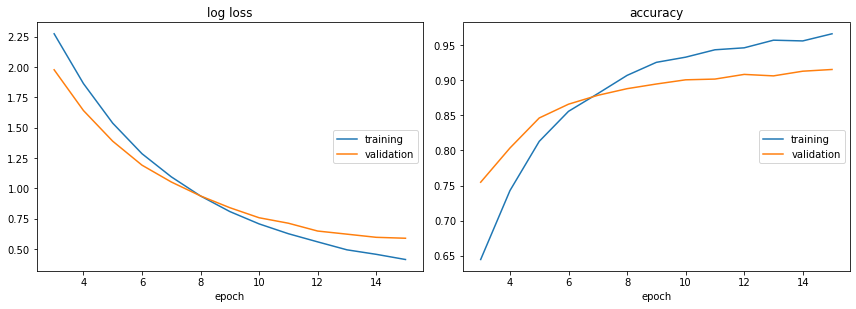

log loss:
training   (min:    0.412, max:    3.746, cur:    0.412)
validation (min:    0.588, max:    3.039, cur:    0.588)

accuracy:
training   (min:    0.223, max:    0.966, cur:    0.966)
validation (min:    0.351, max:    0.915, cur:    0.915)
CPU times: user 3min 58s, sys: 2min 25s, total: 6min 24s
Wall time: 7min 42s


In [0]:

%%time

# Start iterating over the epochs
for epoch in range(NUM_EPOCHS):
  
  logs = {}  # Reset the logs for earch epoch
  print('Starting epoch {}/{}, LR = {}'.format(epoch+1, NUM_EPOCHS, scheduler.get_lr()))
  train_loss = 0                                                                          # Reset the sum of the losses for each epochs in train
  valid_loss = 0                                                                          # Reset the sum of the losses for each epochs in validation
  net.train()                                                                             # Set the net in train mode 
  running_corrects = 0                                                                    # Reset the number of correct predictions on train
  train_dataloader.dataset.transform = train_transform                                    # Switch the transform to be used in __getitem__(): train_transform, first, second or third
  for batch_idx, (images, target) in enumerate(train_dataloader):                         # Start the training using train dataloader batch-by-batch
    images, target = images.to(DEVICE), target.to(DEVICE)
    

    outputs = net(images)
    loss = criterion(outputs, target)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    _, preds = torch.max(outputs, 1)

    train_loss += loss.detach() * images.size(0)                                          # Update the total training loss for this epoch

    running_corrects += torch.sum(preds == target.data)                                   # Update the number of correct predictions on train for this epoch
    if batch_idx % LOG_FREQUENCY == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.4f}'.format(epoch+1, (batch_idx*BATCH_SIZE),
                                                                     (len(train_dataloader)*BATCH_SIZE), 100*(batch_idx/len(train_dataloader)), loss.item()))
  
  train_acc = running_corrects.float() / (len(train_dataloader) * BATCH_SIZE)             # Retrieve the accuracy on train set for this epoch

  net.train(mode=False)                                                                   # Set the net in evaluation mode
  correct = 0                                                                             # Reset the number of correct predictions on validation
  val_dataloader.dataset.transform = valid_transform                                      # Switch the transform to be used in __getitem__(): valid_transform
  with torch.no_grad():
    for data, target in val_dataloader:                                                   # Start the evaluation using validation dataloader batch-by-batch
      data, target = data.to(DEVICE), target.to(DEVICE)
      outputs = net(data)
      loss = criterion(outputs, target)

      valid_loss += loss.detach() * data.size(0)                                          # Update the total validation loss for this epoch
      # Get predictions
      _, preds = torch.max(outputs.data, 1)

      # Update Corrects
      correct += torch.sum(preds == target.data)                                          # Update the number of correct predictions on validation for this epoch

  # Calculate Accuracy
  accuracy = correct / float(len(val_dataloader) * BATCH_SIZE)                            # Retrieve the accuracy on train set for this epoch

  print('\nValidation set accuracy: {:.3f}%\n'.format(
      accuracy*100))
  

  
  valid_loss = valid_loss/(len(val_dataloader)* BATCH_SIZE)                               # Compute the mean validation loss for this epoch
  train_loss = train_loss/(len(train_dataloader) * BATCH_SIZE)                            # Compute the mean train loss for this epoch

  # Log everything
  logs['log loss'] = train_loss.item()
  logs['val_log loss'] = valid_loss.item()
  logs['accuracy'] = train_acc.item()
  logs['val_accuracy'] = accuracy.item()

  print('Validation mean loss: ' + str(valid_loss.item()))
  print('Train mean loss: ' + str(train_loss.item()))
  print('Gap (Validation - Train): ' + str(valid_loss.item() - train_loss.item()))

  if accuracy.item() > best_acc:                                                          # Check for the best accuracy and possibly save it
    best_acc = accuracy
    best_net_acc = copy.deepcopy(net)


  # Implementation of the early stopping mechanism
  '''
  # EARLY STOPPING IMPLEMENTATION
  if valid_loss.item() < min_val_loss:
  # Save the model
    best_net = copy.deepcopy(net)
    epochs_no_improve = 0
    min_val_loss = valid_loss
  
  else:
    epochs_no_improve += 1
    # Check early stopping condition
    if epochs_no_improve == n_epochs_stop:
      print('Early stopping!')
      
      # Load in the best model
      net = copy.deepcopy(best_net)
  '''
  
  liveloss.update(logs)                                                                 # Update the logs for the plotting graph
  if epoch % FREQDRAW == 0:
    liveloss.draw()                                                                     # Draw every FREQDRAW the current graph situation

  scheduler.step()                                                                      # Step the scheduler for the next epoch

liveloss.draw()                                                                         # Draw the residual graph

### **Test**

In [0]:
net = None
best_net = None
net = best_net_acc.to(DEVICE) # this will bring the network to GPU if DEVICE is cuda
net.train(False) # Set Network to evaluation mode

running_corrects = 0
for images, labels in tqdm(test_dataloader):
  images = images.to(DEVICE)
  labels = labels.to(DEVICE)

  # Forward Pass
  outputs = net(images)

  # Get predictions
  _, preds = torch.max(outputs.data, 1)

  # Update Corrects
  running_corrects += torch.sum(preds == labels.data).data.item()

# Calculate Accuracy
accuracy = running_corrects / float(len(test_dataloader.dataset))

print('Test Accuracy: {}'.format(accuracy))

100%|██████████| 58/58 [00:08<00:00,  7.11it/s]

Test Accuracy: 0.9104735568613895
